# Women in Data Science (WiDS) Datathon 2022 - Climate Change Evaluation

The goal of the competition this year is to analyze building energy efficiency and create models to predict building energy consumption, known as 'energy use intensity' (EUI).  The datasets contain building features, energy star ratings, building age, and the weather features where the building is located (anonymized). Energy use by buildings is a contibutor to climate change, and this datathon aims to understand building energy expenditures as a means to combat climate change. 


The datasets follow the Kaggle competition design.  They include training dataset and test dataset.  The training data has the target field but the test data does not.  The goal is to predict the target variable for the test dataset and submit it for scoring in Kaggle.  This dataset has a continuous target variable rather than binary variable.  The scoring by Kaggle is RMSE, which is used throughout my analysis for the project.

 


This jupyter notebook includes the steps required to pre-process the data.  These steps include the following:

1. Initial exploratory analysis of the datasets
2. Drop columns with too many missing values
3. Drop columns that are not needed
4. Evaluate features for outliers, remove if needed
5. One-Hot-Encoding for categorical data
6. Evaluating feature reduction and selection
    - Voting on features based on multiple RFE methods
    - Recursive Feature Elimination (RFE)
        - Lasso
        - Gradient Boosting
        - Random Forest
7. Output dataset to csv for ETL (see notebook #2 for ETL)


In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import normalize, StandardScaler

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression, LassoCV
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.feature_selection import RFE
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor


In [2]:
train = pd.read_csv('wids_train.csv')
test = pd.read_csv('wids_test.csv')

# Data Dictionary

##### Variables
* `id:` building id
* `Year_Factor:` anonymized year in which the weather and energy usage factors were observed
* `State_Factor:` anonymized state in which the building is located
* `building_class:` building classification
* `facility_type:` building usage type
* `floor_area:` floor area (in square feet) of the building
* `year_built:` year in which the building was constructed
* `energy_star_rating:` the energy star rating of the building
* `ELEVATION:` elevation of the building location
* `january_min_temp:` minimum temperature in January (in Fahrenheit) at the location of the building
* `january_avg_temp:` average temperature in January (in Fahrenheit) at the location of the building
* `january_max_temp:` maximum temperature in January (in Fahrenheit) at the location of the building
* `cooling_degree_days:` cooling degree day for a given day is the number of degrees where the daily average temperature exceeds 65 degrees Fahrenheit. Each month is summed to produce an annual total at the location of the building.
* `heating_degree_days:` heating degree day for a given day is the number of degrees where the daily average temperature falls under 65 degrees Fahrenheit. Each month is summed to produce an annual total at the location of the building.
* `precipitation_inches:` annual precipitation in inches at the location of the building
* `snowfall_inches:` annual snowfall in inches at the location of the building
* `snowdepth_inches:` annual snow depth in inches at the location of the building
* `avg_temp:` average temperature over a year at the location of the building
* `days_below_30F:` total number of days below 30 degrees Fahrenheit at the location of the building
* `days_below_20F:` total number of days below 20 degrees Fahrenheit at the location of the building
* `days_below_10F:` total number of days below 10 degrees Fahrenheit at the location of the building
* `days_below_0F:` total number of days below 0 degrees Fahrenheit at the location of the building
* `days_above_80F:` total number of days above 80 degrees Fahrenheit at the location of the building
* `days_above_90F:` total number of days above 90 degrees Fahrenheit at the location of the building
* `days_above_100F:` total number of days above 100 degrees Fahrenheit at the location of the building
* `days_above_110F:` total number of days above 110 degrees Fahrenheit at the location of the building
* `direction_max_wind_speed:` wind direction for maximum wind speed at the location of the building. Given in 360-degree compass point directions (e.g. 360 = north, 180 = south, etc.).
* `direction_peak_wind_speed:` wind direction for peak wind gust speed at the location of the building. Given in 360-degree compass point directions (e.g. 360 = north, 180 = south, etc.).
* `max_wind_speed:` maximum wind speed at the location of the building
* `days_with_fog:` number of days with fog at the location of the building

##### Target
* `site_eui:` Site Energy Usage Intensity is the amount of heat and electricity consumed by a building as reflected in utility bills

# Description of training data

- 63 features
- 1 target column (site_eui) = continuous variable
- 4 categorical features
- 59 numerical features
    - 3 temperature values per month (3x12 = 36)
        - min, average, max values
    - count of days below or above certain temperatures
- 75757 records in training
- 9705 records in test


In [3]:
train.head()

,Year_Factor,State_Factor,building_class,facility_type,floor_area,year_built,energy_star_rating,ELEVATION,january_min_temp,january_avg_temp,...,temp03,temp04,temp05,temp06,temp07,temp08,temp09,temp10,temp11,temp12
0,1,State_1,Commercial,Grocery_store_or_food_market,61242.0,1942.0,11.0,2.4,36,50.5,...,33.177548,7.17,-10.032161,-13.75,-38.951194,-28.56671,-7.083,16.258129,18.6834,26.758194
1,1,State_1,Commercial,Warehouse_Distribution_or_Shipping_center,274000.0,1955.0,45.0,1.8,36,50.5,...,33.177548,7.17,-10.032161,-13.75,-38.951194,-28.56671,-7.083,16.258129,18.6834,26.758194
2,1,State_1,Commercial,Retail_Enclosed_mall,280025.0,1951.0,97.0,1.8,36,50.5,...,33.177548,7.17,-10.032161,-13.75,-38.951194,-28.56671,-7.083,16.258129,18.6834,26.758194
3,1,State_1,Commercial,Education_Other_classroom,55325.0,1980.0,46.0,1.8,36,50.5,...,33.177548,7.17,-10.032161,-13.75,-38.951194,-28.56671,-7.083,16.258129,18.6834,26.758194
4,1,State_1,Commercial,Warehouse_Nonrefrigerated,66000.0,1985.0,100.0,2.4,36,50.5,...,33.177548,7.17,-10.032161,-13.75,-38.951194,-28.56671,-7.083,16.258129,18.6834,26.758194


In [4]:
test.head()

,Year_Factor,State_Factor,building_class,facility_type,floor_area,year_built,energy_star_rating,ELEVATION,january_min_temp,january_avg_temp,...,temp03,temp04,temp05,temp06,temp07,temp08,temp09,temp10,temp11,temp12
0,7,State_1,Commercial,Grocery_store_or_food_market,28484.0,1994.0,37.0,2.4,38,50.596774,...,35.419484,14.12,0.016226,-3.1,-35.418935,-20.873161,14.033667,26.435548,19.9334,26.371097
1,7,State_1,Commercial,Grocery_store_or_food_market,21906.0,1961.0,55.0,45.7,38,50.596774,...,35.419484,14.12,0.016226,-3.1,-35.418935,-20.873161,14.033667,26.435548,19.9334,26.371097
2,7,State_1,Commercial,Grocery_store_or_food_market,16138.0,1950.0,1.0,59.1,38,50.596774,...,35.419484,14.12,0.016226,-3.1,-35.418935,-20.873161,14.033667,26.435548,19.9334,26.371097
3,7,State_1,Commercial,Grocery_store_or_food_market,97422.0,1971.0,34.0,35.4,38,50.596774,...,35.419484,14.12,0.016226,-3.1,-35.418935,-20.873161,14.033667,26.435548,19.9334,26.371097
4,7,State_1,Commercial,Grocery_store_or_food_market,61242.0,1942.0,35.0,1.8,38,50.596774,...,35.419484,14.12,0.016226,-3.1,-35.418935,-20.873161,14.033667,26.435548,19.9334,26.371097


# Evaluating distribution of target variable

The target variable is heavily right-skewed, with a median/mean around 100 and the maximum value close to 1000.  I'm not suprised by the variation in the building energy use, because the dataset contains many different types of buildings, some are factories, others are college campuses, and some are residential homes.  However, all these features need to be considered when building the model and will be evaluated using feature elmination techniques.

Text(0.5, 1.0, 'Boxplot of target variable - Energy use by building')

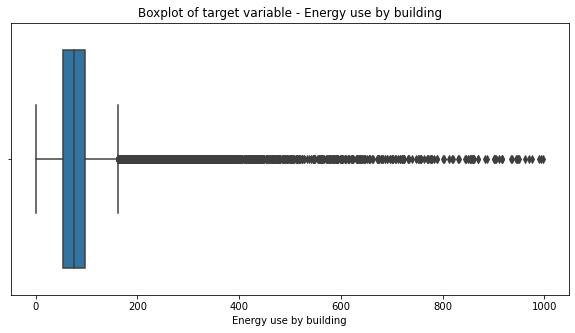

In [5]:
plt.figure(figsize=(10,5))
sns.boxplot(x=train['site_eui'])
plt.xlabel('Energy use by building')
plt.title('Boxplot of target variable - Energy use by building')

Text(0.5, 1.0, 'Distribution of target variable - Energy use by building')

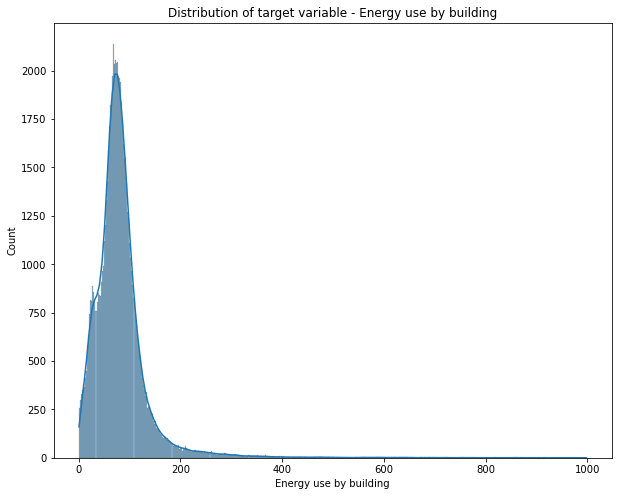

In [6]:
plt.figure(figsize=(10,8))
sns.histplot(data=train, x='site_eui',kde=True)

plt.xlabel('Energy use by building')
plt.title('Distribution of target variable - Energy use by building')

# Missing values in training data

In [6]:
missing_columns = [col for col in train.columns if train[col].isnull().any()]
missingvalues_count =train.isna().sum()
missingValues_df = pd.DataFrame(missingvalues_count.rename('Null Values Count: Train')).loc[missingvalues_count.ne(0)]
missingValues_df.style.background_gradient(cmap="Pastel1")

,Null Values Count: Train
year_built,1837
energy_star_rating,26709
direction_max_wind_speed,41082
direction_peak_wind_speed,41811
max_wind_speed,41082
days_with_fog,45796


# Missing values in test data

In [7]:
missing_columns = [col for col in test.columns if test[col].isnull().any()]
missingvalues_count =test.isna().sum()
missingValues_df = pd.DataFrame(missingvalues_count.rename('Null Values Count: Test')).loc[missingvalues_count.ne(0)]
missingValues_df.style.background_gradient(cmap="Pastel1")

,Null Values Count: Test
year_built,92
energy_star_rating,2254
direction_max_wind_speed,8575
direction_peak_wind_speed,8575
max_wind_speed,8575
days_with_fog,9117


# Dropping variables from training and test data

Many of the variables with missing data have over 50% of the data missing.  These variables will be dropped from the training and test datasets and include: direction_max_wind_speed, direction_peak_wind_speed, max_wind_speed, days_with_fog.  Additionally, the id field will be dropped because it is only an index for the records and doesn't provide additional data.  

Furthermore, the min, max and average temperatures for each month of the year are dropped because a median calculation was derived from the features of the dataset.  A total of 36 columns of data were related to the min, max, and average temperatures.  I decided to calculate the median of each month (min,max,avg) and calculate the difference from the median for each record.  Then, the three median difference calculations (for min,max,avg) were added together to create one value per month that was a representation of it's difference from the median.  It was possible to further join months together to simplify the variables further, but that will be a final step if only necessary to improve the error of the model.


In [5]:
train_drop = train.drop(['direction_max_wind_speed','direction_peak_wind_speed', 
                        'max_wind_speed', 'days_with_fog', 'id',
                        'january_min_temp','january_avg_temp','january_max_temp',
         'february_min_temp','february_avg_temp','february_max_temp',
         'march_min_temp','march_avg_temp','march_max_temp',
         'april_min_temp', 'april_avg_temp', 'april_max_temp',
         'may_min_temp','may_avg_temp','may_max_temp',
         'june_min_temp','june_avg_temp','june_max_temp',
         'july_min_temp','july_avg_temp','july_max_temp',
         'august_min_temp','august_avg_temp','august_max_temp',
         'september_min_temp','september_avg_temp','september_max_temp',
         'october_min_temp','october_avg_temp','october_max_temp',
         'november_min_temp','november_avg_temp','november_max_temp',
         'december_min_temp','december_avg_temp','december_max_temp'],axis=1)
test_drop = test.drop(['direction_max_wind_speed','direction_peak_wind_speed', 
                        'max_wind_speed', 'days_with_fog', 'id',
                        'january_min_temp','january_avg_temp','january_max_temp',
         'february_min_temp','february_avg_temp','february_max_temp',
         'march_min_temp','march_avg_temp','march_max_temp',
         'april_min_temp', 'april_avg_temp', 'april_max_temp',
         'may_min_temp','may_avg_temp','may_max_temp',
         'june_min_temp','june_avg_temp','june_max_temp',
         'july_min_temp','july_avg_temp','july_max_temp',
         'august_min_temp','august_avg_temp','august_max_temp',
         'september_min_temp','september_avg_temp','september_max_temp',
         'october_min_temp','october_avg_temp','october_max_temp',
         'november_min_temp','november_avg_temp','november_max_temp',
         'december_min_temp','december_avg_temp','december_max_temp'],axis=1)

# Impute missing values for training and test data
 
Both the training and test data have energy_star_rating and year_built variables with missing data.  These were imputed using mean and median, respectively.  KNN imputation was tried, but the results were the same as mean/median.

##### year built - imputing zeroes and NaNs

In [6]:
#year built, fill in with mean
#replace zero with mean
train_drop['year_built'] = train_drop['year_built'].replace(np.nan, 1952) #mean
train_drop['year_built'] = train_drop['year_built'].replace(0, 1952) #mean

test_drop['year_built'] = test_drop['year_built'].replace(np.nan, 1952) #mean
test_drop['year_built'] = test_drop['year_built'].replace(0, 1952) #mean

##### energy star rating - imputing zeroes and NaNs

In [7]:
train_drop['energy_star_rating'] = train_drop['energy_star_rating'].fillna(67) #median
train_drop['energy_star_rating'] = train_drop['energy_star_rating'].replace(0,67) #median

test_drop['energy_star_rating'] = test_drop['energy_star_rating'].fillna(67) #median
test_drop['energy_star_rating'] = test_drop['energy_star_rating'].replace(0,67) #median

# Evaluate outliers

Records in training data for year built include zero (which was imputed to a different value since it is incorrect).  There are also values below 1700.  This doesn't seem to be incorrect, but they are outliers for the dataset (in the long-tail). Due to the rarity of that data, these are considered outliers and will be removed.

In [8]:
# Remove build years less than 1700
# finding the index value for recrods with years below 1700
train_drop.sort_values('year_built', ascending=True)

,Year_Factor,State_Factor,building_class,facility_type,floor_area,year_built,energy_star_rating,ELEVATION,cooling_degree_days,heating_degree_days,...,temp03,temp04,temp05,temp06,temp07,temp08,temp09,temp10,temp11,temp12
35472,4,State_6,Commercial,Office_Uncategorized,276000.0,1600.0,83.0,42.7,1128,4875,...,-23.854710,-6.996667,2.113000,2.200000,-7.531839,-2.211871,0.000333,1.871032,-13.816600,0.000129
44951,5,State_6,Commercial,Office_Uncategorized,276000.0,1600.0,81.0,42.7,1581,4460,...,-28.419226,-1.080000,7.629129,-3.066667,1.113323,9.239742,13.717000,-5.709613,8.666733,27.258194
15123,1,State_6,Commercial,Office_Uncategorized,276000.0,1600.0,87.0,42.7,1331,4335,...,-1.193419,4.970000,2.596871,9.066667,9.564935,0.546194,-6.699667,-2.661226,7.766733,-2.209548
26876,3,State_6,Commercial,Office_Uncategorized,276000.0,1600.0,79.0,25.6,1272,4670,...,-14.370839,0.653333,-2.096677,3.400000,4.161710,-4.131226,-2.866333,9.435548,-11.866600,-0.967613
56260,6,State_6,Commercial,Office_Uncategorized,276000.0,1600.0,85.0,42.7,1489,4252,...,13.354968,-5.996667,0.903323,-2.000000,0.000419,8.449419,3.067000,5.000065,5.650067,-14.177290
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57392,6,State_6,Residential,Multifamily_Uncategorized,250000.0,2015.0,72.0,42.7,1489,4252,...,13.354968,-5.996667,0.903323,-2.000000,0.000419,8.449419,3.067000,5.000065,5.650067,-14.177290
68417,6,State_8,Residential,Multifamily_Uncategorized,55000.0,2015.0,17.0,3.0,1114,5074,...,8.451742,-18.398966,-11.725710,-8.784483,-7.593667,-3.002194,-9.533000,-12.499935,-14.799933,-24.386968
13761,6,State_4,Commercial,Lodging_Dormitory_or_fraternity_sorority,184000.0,2015.0,22.0,219.8,986,5995,...,-20.016000,-16.863333,-16.032161,-3.678571,-19.427000,-11.324774,-4.299667,-5.822516,-10.271772,-64.725677
63997,6,State_6,Commercial,Warehouse_Selfstorage,96890.0,2015.0,67.0,25.0,1489,4252,...,13.354968,-5.996667,0.903323,-2.000000,0.000419,8.449419,3.067000,5.000065,5.650067,-14.177290


In [9]:
#removing indexes 
train_remove = train_drop.drop([35472,44951,15123,26876,56260,19948,56882,35896,24302,27251])
#train_remove.head(3)

In [8]:
#to csv
train_remove.to_csv('train_before_ohe.csv')

# Evaluate distribution after outlier removal and imputation

Based on the lack of normalized distribution in the features and the variation in scales across the features, it is clear that standardization will be needed before running the models.

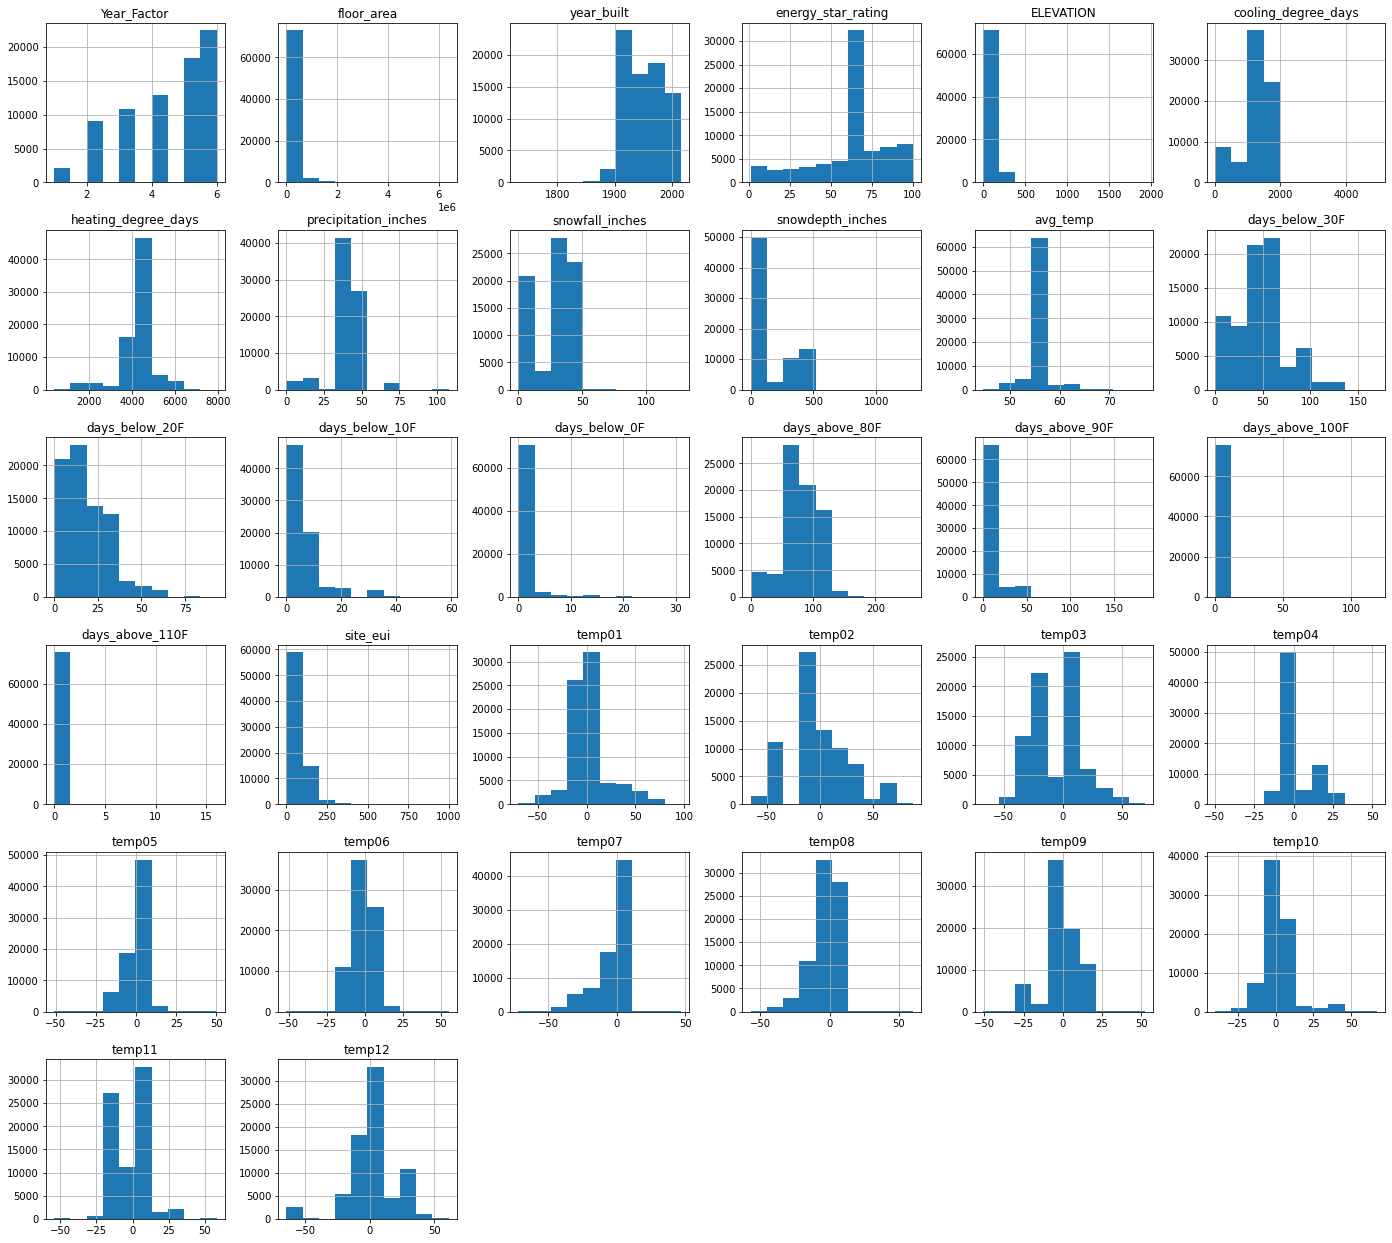

In [11]:
#view distributions of variables
plt.rcParams['figure.figsize'] = (24,22)
# histograms = train_remove.drop([''])
_ = train_remove.hist()
plt.show()

# One Hot Encoding for categorical variables

In [26]:
train_ohe = pd.get_dummies(train_remove,columns=['State_Factor','building_class','facility_type']) #drop_first=True
test_ohe = pd.get_dummies(test_drop,columns=['State_Factor','building_class','facility_type'])
train_ohe.head()

,Year_Factor,floor_area,year_built,energy_star_rating,ELEVATION,cooling_degree_days,heating_degree_days,precipitation_inches,snowfall_inches,snowdepth_inches,...,facility_type_Retail_Uncategorized,facility_type_Retail_Vehicle_dealership_showroom,facility_type_Service_Drycleaning_or_Laundry,facility_type_Service_Uncategorized,facility_type_Service_Vehicle_service_repair_shop,facility_type_Warehouse_Distribution_or_Shipping_center,facility_type_Warehouse_Nonrefrigerated,facility_type_Warehouse_Refrigerated,facility_type_Warehouse_Selfstorage,facility_type_Warehouse_Uncategorized
0,1,61242.0,1942.0,11.0,2.4,115,2960,16.59,0.0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,274000.0,1955.0,45.0,1.8,115,2960,16.59,0.0,0,...,0,0,0,0,0,1,0,0,0,0
2,1,280025.0,1951.0,97.0,1.8,115,2960,16.59,0.0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,55325.0,1980.0,46.0,1.8,115,2960,16.59,0.0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,66000.0,1985.0,100.0,2.4,115,2960,16.59,0.0,0,...,0,0,0,0,0,0,1,0,0,0


In [27]:
#output the training and test data to csv for use in next notebook

train_ohe.to_csv('train_preprocessed.csv', index=False)
test_ohe.to_csv('test_preprocessed.csv',index=False)

In [30]:
#see all columns!!
pd.set_option('display.max_columns', None)
display(train_ohe)

Index(['floor_area', 'year_built', 'energy_star_rating', 'ELEVATION',
       'january_min_temp', 'january_avg_temp', 'january_max_temp',
       'february_min_temp', 'february_avg_temp', 'february_max_temp',
       ...
       'facility_type_Retail_Uncategorized',
       'facility_type_Retail_Vehicle_dealership_showroom',
       'facility_type_Service_Drycleaning_or_Laundry',
       'facility_type_Service_Uncategorized',
       'facility_type_Service_Vehicle_service_repair_shop',
       'facility_type_Warehouse_Distribution_or_Shipping_center',
       'facility_type_Warehouse_Nonrefrigerated',
       'facility_type_Warehouse_Refrigerated',
       'facility_type_Warehouse_Selfstorage',
       'facility_type_Warehouse_Uncategorized'],
      dtype='object', length=126)

# Categorical Variables - Facility Type (60!)

There are 60 facility types!  I evaluated the facilities and other categorical variables graphically to see if any relationships emerge.  The first place to start to determine which of the 60 aren't needed.  I looked at the boxplot distributions of the energy use across the different facilities, and found that many are clustered (IQR) around the 100 to 200 range, and there is a lot of variation within each facility.  The hard part here is to decide to remove the 'outliers', group like features, or to remove ones with huge variations.  Because it isn't obvious what approach is best just by looking at the data (sometimes it is, but it isn't for these data), I will rely on recursive feature elimination methods to show which facilities to exclude from the dataset.


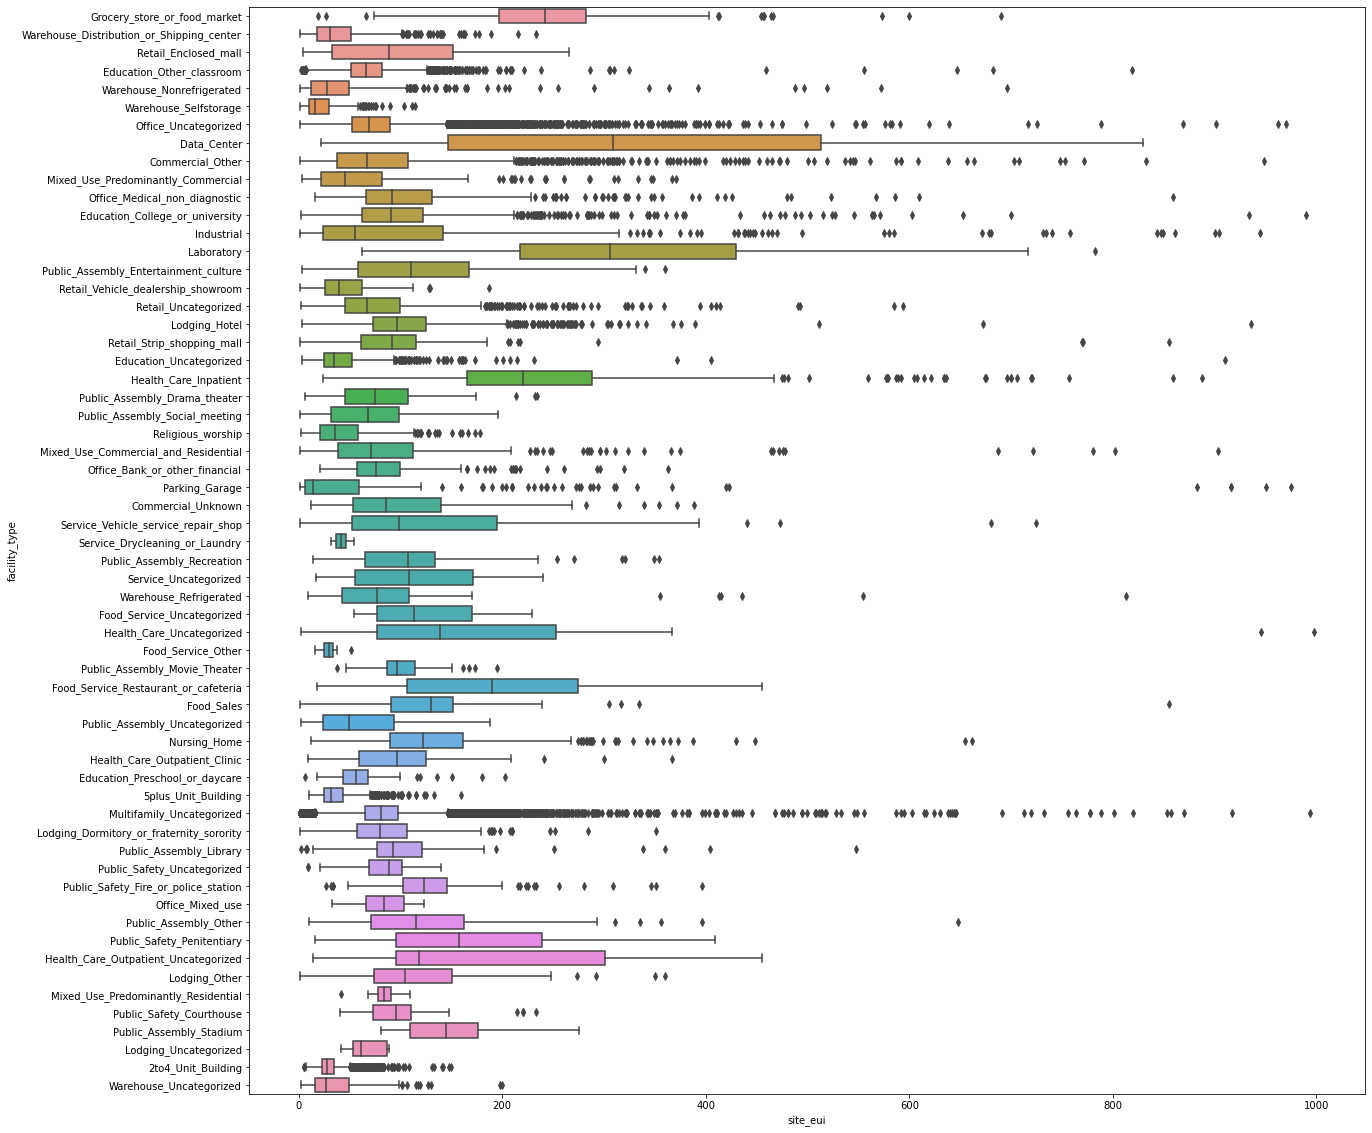

In [18]:
fig = plt.figure(figsize = (20,20))
facility_dist = sns.boxplot(x='site_eui',y='facility_type',data=train_remove)
plt.show()

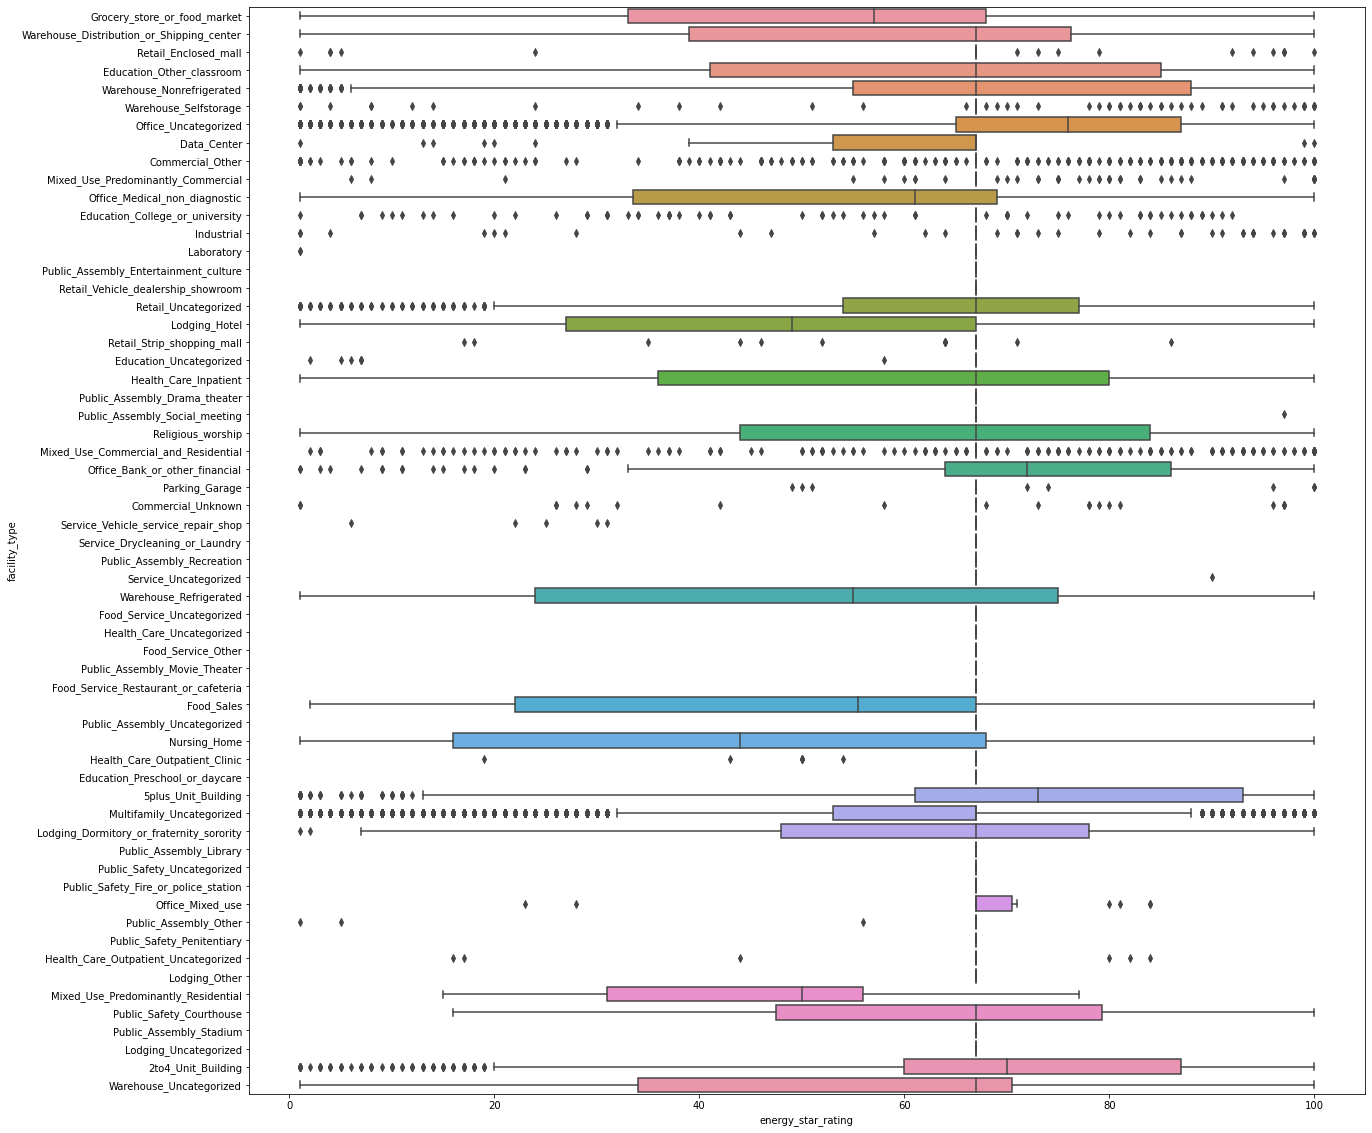

In [23]:
fig = plt.figure(figsize = (20,20))
energy_star_dist = sns.boxplot(x='energy_star_rating',y='facility_type',data=train_remove)
plt.show()

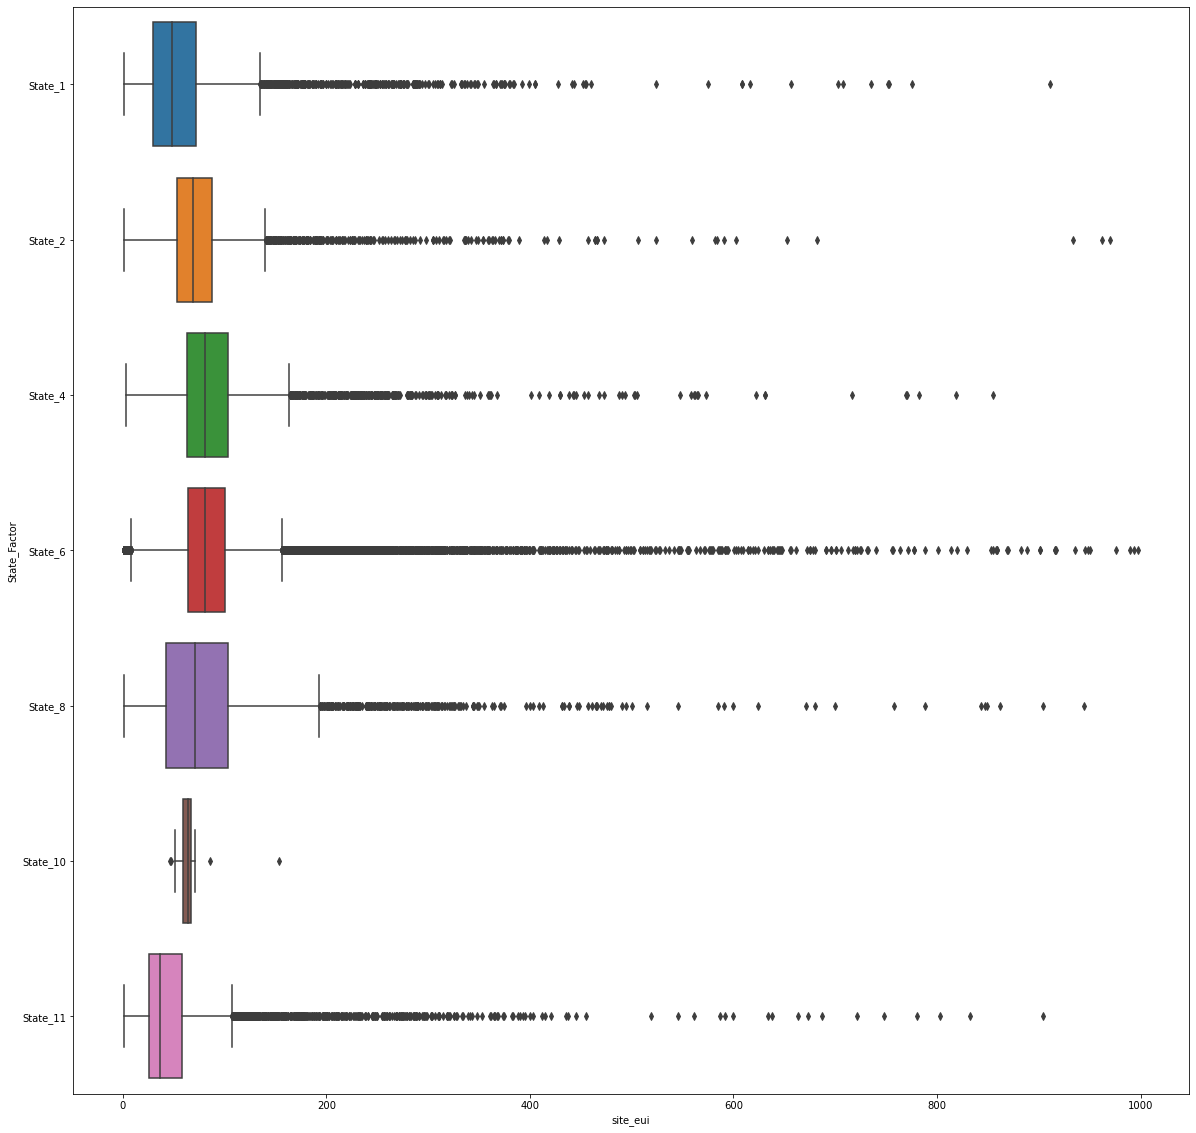

In [19]:
fig = plt.figure(figsize = (20,10))
state_dist = sns.boxplot(x='site_eui',y='State_Factor',data=train_remove)
plt.show()

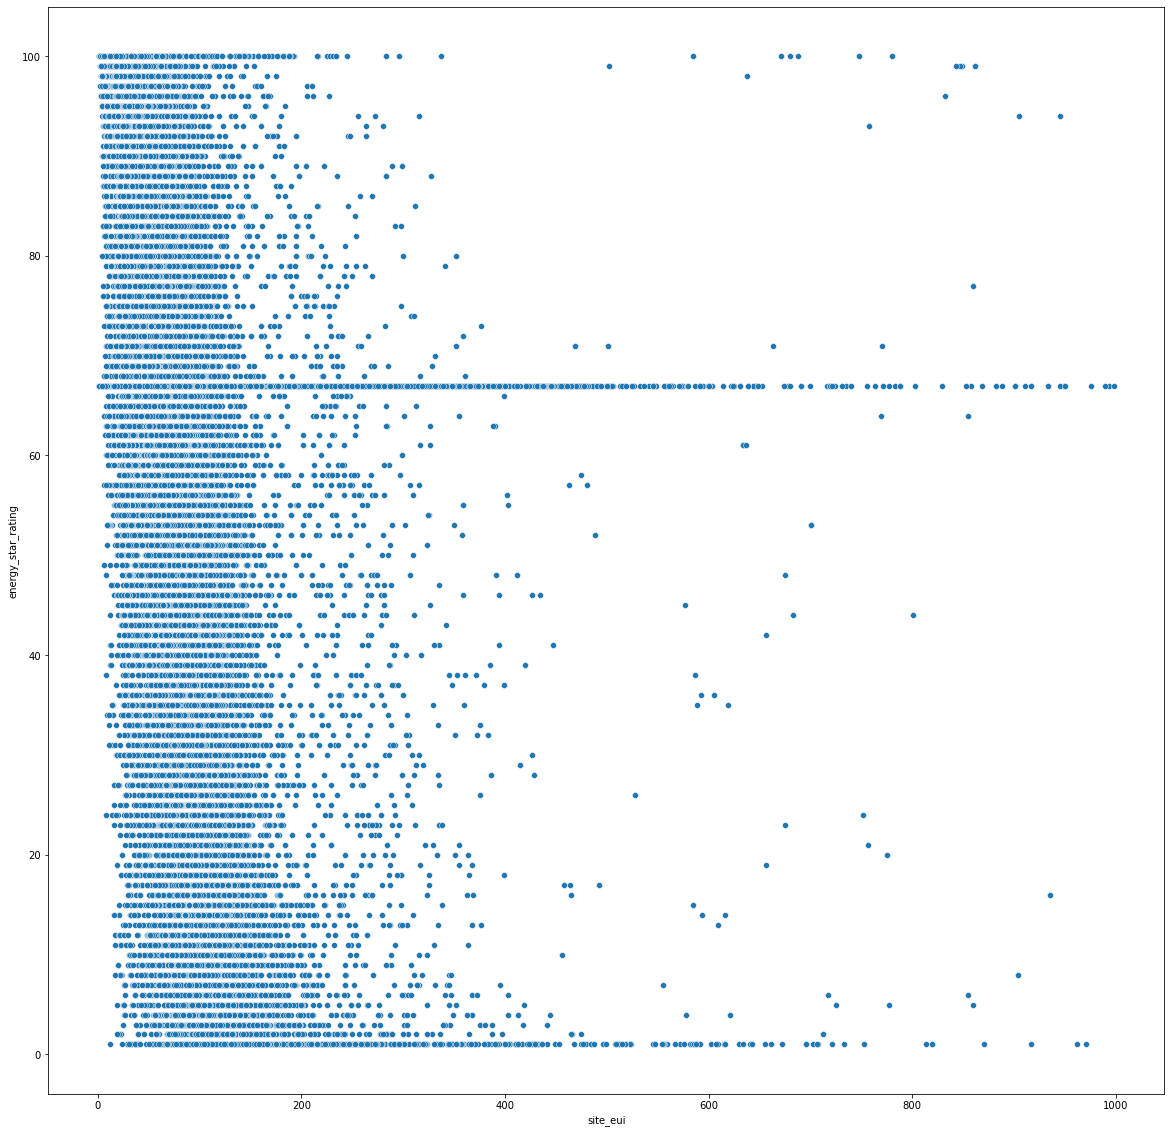

In [52]:
fig = plt.figure(figsize = (20,20))
energy_star_dist = sns.scatterplot(x='site_eui',y='energy_star_rating',data=train_remove)
plt.show()

# Feature Selection and Reduction
_______________________________

There are way too many features in the dataset and they need to be pared down to the essential ones that are the most predictive in the model.  First, the data were train/test/split and three different methods were used and then voted on.  The combination of the voting on each feature by the three methods earned the feature a keep or reject status as input for the final set of models.  The three techniques were LassoCV, RandomForestRegressor and GradientBoostRegressor, using Recursive Feature Selection for the latter two techniques.  These operations were made into functions so that they could be called several times with different setups.  The first evaluation used only the numerical features and excluded any that were categorical, and the features were scaled using StandardScaler.  The next feature evaluation was completed using the full dataset including the one-hot-encoded features using StandardScaler, and then again using Normalize.  I wanted to see if there was a difference in using those two scaling techniques.

When only numeric fields were evaluated, some of the temperature features were eliminated:

#### Numeric only
* cooling degree days
* snowdepth inches
* days below 10
* days above 90
* days above 110
* temp08 (august)

When standardscaler and normalize scaling techniques were compared (for all fields), there were a few differences.  A few of the temperature fields were different and some of the facility types (one-hot-encoded).  See the table below for the voting result and the feature.  Any that were ranked as a zero or one (only got that many votes through the voting method) were eliminated and a select few of the facility encoded features were eliminated too. This dropped the count to 67 features!

## Comparing ranking of standardscaler and normalize on all fields

|StandardScaler method||vote||                    ||Normalize method||vote|
|---||---||---||---||---|  
|days_above_110F||1||          ||State_Factor_State_4||0|
|State_Factor_State_10||1||          ||facility_type_Mixed_Use_Predominantly_Residential||1|
|facility_type_Food_Service_Other||1||          ||State_Factor_State_1||1|
|facility_type_Health_Care_Outpatient_Clinic||1||          ||State_Factor_State_10||1|
|facility_type_Public_Assembly_Movie_Theater||1||          ||facility_type_Food_Service_Other||1|
|facility_type_Public_Assembly_Stadium||1||          ||facility_type_Public_Assembly_Movie_Theater||1|
|facility_type_Public_Assembly_Uncategorized||1||          ||facility_type_Public_Assembly_Stadium||1|
|facility_type_Public_Safety_Uncategorized||1||          ||     |
|avg_temp||2||          ||avg_temp||2|
|temp01||2||          ||temp01||2|
|temp02||2||          ||temp02||2| 
|temp05||2||          ||temp06||2|
|temp06||2||          ||temp07||2| 
|temp08||2||          ||temp10||2| 
|temp11||2||          ||temp11||2|
|facility_type_Food_Service_Uncategorized ||2 || ||facility_type_Food_Service_Uncategorized  ||2|
|facility_type_Public_Assembly_Other ||2 ||  ||facility_type_Commercial_Unknown  ||2|
|facility_type_Mixed_Use_Predominantly_Residential ||2 ||  ||facility_type_Food_Sales  ||2|
|facility_type_Lodging_Uncategorized ||2 || ||facility_type_Lodging_Uncategorized  ||2|
|facility_type_Multifamily_Uncategorized  ||2 || ||facility_type_Multifamily_Uncategorized  ||2|
|facility_type_Lodging_Other ||2 ||  ||facility_type_Office_Bank_or_other_financial  ||2|
|facility_type_Office_Mixed_use || 2|| ||facility_type_Office_Mixed_use ||2|
|facility_type_Office_Uncategorized || 2|| ||facility_type_Office_Uncategorized||2|
|facility_type_Public_Assembly_Recreation ||2 || ||facility_type_Public_Assembly_Drama_theater||2|
| || || ||facility_type_Public_Assembly_Entertainment_culture||2|
|facility_type_Public_Assembly_Library ||2 || ||facility_type_Public_Assembly_Library||2|
|facility_type_Lodging_Dormitory_or_fraternity_sorority ||2 || ||facility_type_Public_Assembly_Social_meeting||2|
| || || ||facility_type_Public_Assembly_Uncategorized||2|
|facility_type_Public_Safety_Courthouse ||2 || ||facility_type_Public_Safety_Courthouse||2|
| || || ||facility_type_Public_Safety_Uncategorized||2|
|facility_type_Retail_Enclosed_mall ||2 || ||facility_type_Retail_Enclosed_mall||2|
|facility_type_Retail_Vehicle_dealership_showroom ||2 || ||facility_type_Retail_Vehicle_dealership_showroom||2|
|facility_type_Service_Drycleaning_or_Laundry ||2 || ||facility_type_Service_Drycleaning_or_Laundry||2|

## Feature selection - numerical only

### create model dataset & train-test-split (numeric columns, standardscaler)

In [66]:
train_numeric = train_remove.drop(columns=['State_Factor','building_class','facility_type'],axis=1)

#create data
X = train_numeric.drop(['site_eui'],axis=1)
y = train_numeric['site_eui']

#train-test-split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=44)
#scale data
scaler=StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)


### Lasso

In [31]:
def lasso(X_train,X_test,y_train,y_test,dataset):
    # Create and fit the LassoCV model on the training set
    print(f'LassoCV report for {dataset}:')
    lcv = LassoCV()
    lcv.fit(X_train, y_train)
    print('Optimal alpha = {0:.3f}'.format(lcv.alpha_))

    # Calculate R squared on the test set
    r_squared = lcv.score(X_test, y_test)
    print('The model explains {0:.1%} of the test set variance'.format(r_squared))

    # Create a mask for coefficients not equal to zero
    lcv_mask = lcv.coef_ != 0
    print('{} features out of {} selected'.format(sum(lcv_mask), len(lcv_mask)))
    
    lasso.var = lcv_mask

In [55]:
#call function
lasso(X_train,X_test,y_train,y_test,'numeric columns using standardscaler')

LassoCV report for numeric columns using standardscaler:
Optimal alpha = 0.022
The model explains 15.9% of the test set variance
25 features out of 31 selected


### Random Forest Regressor

In [32]:
def random_forest_regressor(X_train,X_test,y_train,y_test,features,dataset):
    print(f'RandomForestRegressor report for {dataset}:')
    rfe_rf = RFE(estimator=RandomForestRegressor(),
                    n_features_to_select=features, step=2, verbose=2) 
    rfe_rf.fit(X_train,y_train)

    y_pred_rfe = rfe_rf.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test,y_pred_rfe))
    print(f'RMSE RFE with random forest regressor: {rmse}')
    rf_mask = rfe_rf.support_
    
    random_forest_regressor.var = rf_mask

In [57]:
#call function
random_forest_regressor(X_train,X_test,y_train,y_test,25,'numeric columns using standardscaler')

RandomForestRegressor report for numeric columns using standardscaler:
Fitting estimator with 31 features.
Fitting estimator with 29 features.
Fitting estimator with 27 features.
RMSE RFE with random forest regressor: 56.013407678625185


### Gradient Boost Regressor

In [33]:
def gradient_boost_regressor(X_train,X_test,y_train,y_test,features,dataset):
    print(f'GradientBoostRegressor report for {dataset}:')
    rfe_gb = RFE(estimator=GradientBoostingRegressor(),
                n_features_to_select=features, step=2, verbose=2)

    rfe_gb.fit(X_train,y_train)
    gb_mask = rfe_gb.support_
    
    y_pred_gb = rfe_gb.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test,y_pred_gb))
    print(f'RMSE RFE with gradient boosting: {rmse}')
    gradient_boost_regressor.var = gb_mask

In [59]:
#call function
gradient_boost_regressor(X_train,X_test,y_train,y_test,25,'numeric columns using standardscaler')

GradientBoostRegressor report for numeric columns using standardscaler:
Fitting estimator with 31 features.
Fitting estimator with 29 features.
Fitting estimator with 27 features.
RMSE RFE with gradient boosting: 54.85513888109681


### Majority voting for feature reduction (lasso, random forest, and gradient boost)
The results of the three methods are combined and the features with the highest scores are selected.  This selection resulted in the following numeric features being ruled out:

- cooling degree days
- snowdepth inches
- days below 10
- days above 90
- days above 110
- temp08 (august)

In [34]:
def reduction_voting(rf_mask,gb_mask,lcv_mask,dataset):
    print(f'feature reduction voting report for {dataset}:')
    votes = np.sum([rf_mask,gb_mask,lcv_mask],axis=0) #could exclude lcv depending if it runs
    print(votes)
    #votes are how many of the models selected that feature (vote = keep in the model)
    rfe_mask = votes >=2 #number of votes to include 
    rfe_reduced_X = X.loc[:,rfe_mask]
    return rfe_reduced_X.columns   

In [65]:
#call function
reduction_voting(random_forest_regressor.var,gradient_boost_regressor.var,lasso.var,'numeric columns using standardscaler')

feature reduction voting report for numeric columns using standardscaler:
[3 3 3 3 3 0 3 3 3 3 2 3 3 1 2 2 1 2 0 3 3 3 2 3 3 3 1 3 3 2 3]


Index(['Year_Factor', 'floor_area', 'year_built', 'energy_star_rating',
       'ELEVATION', 'heating_degree_days', 'precipitation_inches',
       'snowfall_inches', 'snowdepth_inches', 'avg_temp', 'days_below_30F',
       'days_below_20F', 'days_below_0F', 'days_above_80F', 'days_above_100F',
       'temp01', 'temp02', 'temp03', 'temp04', 'temp05', 'temp06', 'temp07',
       'temp09', 'temp10', 'temp11', 'temp12'],
      dtype='object')

## Feature selection with all variables using StandardScaler
#### calling the functions from above

In [35]:
#create model dataset
X = train_ohe.drop(['site_eui'],axis=1)
y = train_ohe['site_eui']
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=33)
#scale data
scaler=StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [36]:
lasso(X_train,X_test,y_train,y_test,'all columns with OHE using standardscaler')

LassoCV report for all columns with OHE using standardscaler:
Optimal alpha = 0.025
The model explains 34.4% of the test set variance
86 features out of 100 selected


In [37]:
random_forest_regressor(X_train,X_test,y_train,y_test,86,'all columns with OHE using standardscaler')

RandomForestRegressor report for all columns with OHE using standardscaler:
Fitting estimator with 100 features.
Fitting estimator with 98 features.
Fitting estimator with 96 features.
Fitting estimator with 94 features.
Fitting estimator with 92 features.
Fitting estimator with 90 features.
Fitting estimator with 88 features.
RMSE RFE with random forest regressor: 42.49882249427407


In [38]:
gradient_boost_regressor(X_train,X_test,y_train,y_test,86,'all columns with OHE using standardscaler')

GradientBoostRegressor report for all columns with OHE using standardscaler:
Fitting estimator with 100 features.
Fitting estimator with 98 features.
Fitting estimator with 96 features.
Fitting estimator with 94 features.
Fitting estimator with 92 features.
Fitting estimator with 90 features.
Fitting estimator with 88 features.
RMSE RFE with gradient boosting: 45.693519967361304


In [39]:
reduction_voting(random_forest_regressor.var,gradient_boost_regressor.var,lasso.var,'all columns with OHE using standardscaler')

feature reduction voting report for all columns with OHE using standardscaler:
[3 3 3 3 3 3 3 3 3 3 2 3 3 3 3 3 3 3 1 2 2 3 3 2 2 3 2 3 3 2 3 2 1 2 3 2 3
 3 3 2 3 3 3 3 3 3 3 3 3 3 1 3 2 3 3 1 3 3 3 3 2 3 2 2 3 3 2 2 3 3 3 2 2 3
 3 3 2 1 2 2 3 1 1 2 3 3 1 3 2 3 3 2 2 3 3 3 3 3 3 3]


Index(['Year_Factor', 'floor_area', 'year_built', 'energy_star_rating',
       'ELEVATION', 'cooling_degree_days', 'heating_degree_days',
       'precipitation_inches', 'snowfall_inches', 'snowdepth_inches',
       'avg_temp', 'days_below_30F', 'days_below_20F', 'days_below_10F',
       'days_below_0F', 'days_above_80F', 'days_above_90F', 'days_above_100F',
       'temp01', 'temp02', 'temp03', 'temp04', 'temp05', 'temp06', 'temp07',
       'temp08', 'temp09', 'temp10', 'temp11', 'temp12',
       'State_Factor_State_1', 'State_Factor_State_11', 'State_Factor_State_2',
       'State_Factor_State_4', 'State_Factor_State_6', 'State_Factor_State_8',
       'building_class_Commercial', 'building_class_Residential',
       'facility_type_2to4_Unit_Building', 'facility_type_5plus_Unit_Building',
       'facility_type_Commercial_Other', 'facility_type_Commercial_Unknown',
       'facility_type_Data_Center',
       'facility_type_Education_College_or_university',
       'facility_type_Education_

In [41]:
#see all columns!!
pd.set_option('display.max_columns', None)
display(train_ohe)

,Year_Factor,floor_area,year_built,energy_star_rating,ELEVATION,cooling_degree_days,heating_degree_days,precipitation_inches,snowfall_inches,snowdepth_inches,avg_temp,days_below_30F,days_below_20F,days_below_10F,days_below_0F,days_above_80F,days_above_90F,days_above_100F,days_above_110F,site_eui,temp01,temp02,temp03,temp04,temp05,temp06,temp07,temp08,temp09,temp10,temp11,temp12,State_Factor_State_1,State_Factor_State_10,State_Factor_State_11,State_Factor_State_2,State_Factor_State_4,State_Factor_State_6,State_Factor_State_8,building_class_Commercial,building_class_Residential,facility_type_2to4_Unit_Building,facility_type_5plus_Unit_Building,facility_type_Commercial_Other,facility_type_Commercial_Unknown,facility_type_Data_Center,facility_type_Education_College_or_university,facility_type_Education_Other_classroom,facility_type_Education_Preschool_or_daycare,facility_type_Education_Uncategorized,facility_type_Food_Sales,facility_type_Food_Service_Other,facility_type_Food_Service_Restaurant_or_cafeteria,facility_type_Food_Service_Uncategorized,facility_type_Grocery_store_or_food_market,facility_type_Health_Care_Inpatient,facility_type_Health_Care_Outpatient_Clinic,facility_type_Health_Care_Outpatient_Uncategorized,facility_type_Health_Care_Uncategorized,facility_type_Industrial,facility_type_Laboratory,facility_type_Lodging_Dormitory_or_fraternity_sorority,facility_type_Lodging_Hotel,facility_type_Lodging_Other,facility_type_Lodging_Uncategorized,facility_type_Mixed_Use_Commercial_and_Residential,facility_type_Mixed_Use_Predominantly_Commercial,facility_type_Mixed_Use_Predominantly_Residential,facility_type_Multifamily_Uncategorized,facility_type_Nursing_Home,facility_type_Office_Bank_or_other_financial,facility_type_Office_Medical_non_diagnostic,facility_type_Office_Mixed_use,facility_type_Office_Uncategorized,facility_type_Parking_Garage,facility_type_Public_Assembly_Drama_theater,facility_type_Public_Assembly_Entertainment_culture,facility_type_Public_Assembly_Library,facility_type_Public_Assembly_Movie_Theater,facility_type_Public_Assembly_Other,facility_type_Public_Assembly_Recreation,facility_type_Public_Assembly_Social_meeting,facility_type_Public_Assembly_Stadium,facility_type_Public_Assembly_Uncategorized,facility_type_Public_Safety_Courthouse,facility_type_Public_Safety_Fire_or_police_station,facility_type_Public_Safety_Penitentiary,facility_type_Public_Safety_Uncategorized,facility_type_Religious_worship,facility_type_Retail_Enclosed_mall,facility_type_Retail_Strip_shopping_mall,facility_type_Retail_Uncategorized,facility_type_Retail_Vehicle_dealership_showroom,facility_type_Service_Drycleaning_or_Laundry,facility_type_Service_Uncategorized,facility_type_Service_Vehicle_service_repair_shop,facility_type_Warehouse_Distribution_or_Shipping_center,facility_type_Warehouse_Nonrefrigerated,facility_type_Warehouse_Refrigerated,facility_type_Warehouse_Selfstorage,facility_type_Warehouse_Uncategorized
0,1,61242.0,1942.0,11.0,2.4,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,248.682615,50.048400,54.572286,33.177548,7.170000,-10.032161,-13.750000,-38.951194,-28.566710,-7.083000,16.258129,18.683400,26.758194,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,274000.0,1955.0,45.0,1.8,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,26.500150,50.048400,54.572286,33.177548,7.170000,-10.032161,-13.750000,-38.951194,-28.566710,-7.083000,16.258129,18.683400,26.758194,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,1,280025.0,1951.0,97.0,1.8,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,24.693619,50.048400,54.572286,33.177548,7.170000,-10.032161,-13.750000,-38.951194,-28.566710,-7.083000,16.258129,18.683400,26.758194,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


## Feature selection - all variables using Normalize

In [42]:
X = train_ohe.drop(['site_eui'],axis=1)
X_norm = normalize(X,axis=0)
y = train_ohe['site_eui']
X_train,X_test,y_train,y_test = train_test_split(X_norm,y,test_size=0.3,random_state=44)

In [43]:
lasso(X_train,X_test,y_train,y_test,'all columns with OHE using normalize')

LassoCV report for all columns with OHE using normalize:
Optimal alpha = 0.000
The model explains 34.5% of the test set variance
83 features out of 100 selected


In [44]:
random_forest_regressor(X_train,X_test,y_train,y_test,83,'all columns with OHE using normalize')

RandomForestRegressor report for all columns with OHE using normalize:
Fitting estimator with 100 features.
Fitting estimator with 98 features.
Fitting estimator with 96 features.
Fitting estimator with 94 features.
Fitting estimator with 92 features.
Fitting estimator with 90 features.
Fitting estimator with 88 features.
Fitting estimator with 86 features.
Fitting estimator with 84 features.
RMSE RFE with random forest regressor: 41.55645943410706


In [45]:
gradient_boost_regressor(X_train,X_test,y_train,y_test,83,'all columns with OHE using normalize')

GradientBoostRegressor report for all columns with OHE using normalize:
Fitting estimator with 100 features.
Fitting estimator with 98 features.
Fitting estimator with 96 features.
Fitting estimator with 94 features.
Fitting estimator with 92 features.
Fitting estimator with 90 features.
Fitting estimator with 88 features.
Fitting estimator with 86 features.
Fitting estimator with 84 features.
RMSE RFE with gradient boosting: 46.35000911213082


In [46]:
reduction_voting(random_forest_regressor.var,gradient_boost_regressor.var,lasso.var,'all columns with OHE using normalize')

feature reduction voting report for all columns with OHE using normalize:
[2 3 2 3 3 2 2 3 3 3 2 2 3 3 3 3 3 3 2 2 2 3 3 3 2 2 2 3 2 2 3 1 1 2 2 0 3
 3 3 2 3 3 3 2 3 3 3 3 3 2 1 3 2 3 3 3 3 3 3 3 3 3 3 2 3 3 0 2 3 2 3 2 2 3
 2 2 2 1 3 3 2 1 2 2 3 3 2 3 2 3 3 2 2 3 3 3 3 3 3 3]


Index(['Year_Factor', 'floor_area', 'year_built', 'energy_star_rating',
       'ELEVATION', 'cooling_degree_days', 'heating_degree_days',
       'precipitation_inches', 'snowfall_inches', 'snowdepth_inches',
       'avg_temp', 'days_below_30F', 'days_below_20F', 'days_below_10F',
       'days_below_0F', 'days_above_80F', 'days_above_90F', 'days_above_100F',
       'days_above_110F', 'temp01', 'temp02', 'temp03', 'temp04', 'temp05',
       'temp06', 'temp07', 'temp08', 'temp09', 'temp10', 'temp11', 'temp12',
       'State_Factor_State_11', 'State_Factor_State_2', 'State_Factor_State_6',
       'State_Factor_State_8', 'building_class_Commercial',
       'building_class_Residential', 'facility_type_2to4_Unit_Building',
       'facility_type_5plus_Unit_Building', 'facility_type_Commercial_Other',
       'facility_type_Commercial_Unknown', 'facility_type_Data_Center',
       'facility_type_Education_College_or_university',
       'facility_type_Education_Other_classroom',
       'facility_t

### drop features based on RFE

In [47]:
energy_df = train_ohe.drop(['days_above_110F',
                            'State_Factor_State_10',
                            'facility_type_Food_Service_Other',
                            'State_Factor_State_1',
                            'facility_type_Public_Assembly_Movie_Theater',
                            'facility_type_Public_Assembly_Stadium',
                            'building_class_Residential',
                            'facility_type_Mixed_Use_Predominantly_Residential',
                            'State_Factor_State_4',
                            'facility_type_Public_Assembly_Uncategorized',
                            'facility_type_Public_Safety_Uncategorized',
                            'avg_temp',
                            'temp01',
                            'temp02',
                            'temp06',
                            'temp08',
                            'temp11',
                            'State_Factor_State_11',
                            'facility_type_Commercial_Unknown',
                            'facility_type_Food_Sales',
                            'facility_type_Food_Service_Uncategorized',
                            'facility_type_Lodging_Uncategorized',
                            'facility_type_Multifamily_Uncategorized',
                            'facility_type_Office_Bank_or_other_financial',
                            'facility_type_Office_Mixed_use',
                            'facility_type_Office_Uncategorized',
                            'facility_type_Public_Assembly_Drama_theater',
                            'facility_type_Public_Assembly_Entertainment_culture',
                            'facility_type_Public_Assembly_Library',
                            'facility_type_Public_Assembly_Social_meeting',
                            'facility_type_Public_Assembly_Uncategorized',
                            'facility_type_Public_Safety_Courthouse',
                            'facility_type_Public_Safety_Uncategorized',
                            'facility_type_Retail_Enclosed_mall',
                            'facility_type_Retail_Vehicle_dealership_showroom',
                            'facility_type_Service_Drycleaning_or_Laundry'],axis=1)

energy_df.head()

,Year_Factor,floor_area,year_built,energy_star_rating,ELEVATION,cooling_degree_days,heating_degree_days,precipitation_inches,snowfall_inches,snowdepth_inches,days_below_30F,days_below_20F,days_below_10F,days_below_0F,days_above_80F,days_above_90F,days_above_100F,site_eui,temp03,temp04,temp05,temp07,temp09,temp10,temp12,State_Factor_State_2,State_Factor_State_6,State_Factor_State_8,building_class_Commercial,facility_type_2to4_Unit_Building,facility_type_5plus_Unit_Building,facility_type_Commercial_Other,facility_type_Data_Center,facility_type_Education_College_or_university,facility_type_Education_Other_classroom,facility_type_Education_Preschool_or_daycare,facility_type_Education_Uncategorized,facility_type_Food_Service_Restaurant_or_cafeteria,facility_type_Grocery_store_or_food_market,facility_type_Health_Care_Inpatient,facility_type_Health_Care_Outpatient_Clinic,facility_type_Health_Care_Outpatient_Uncategorized,facility_type_Health_Care_Uncategorized,facility_type_Industrial,facility_type_Laboratory,facility_type_Lodging_Dormitory_or_fraternity_sorority,facility_type_Lodging_Hotel,facility_type_Lodging_Other,facility_type_Mixed_Use_Commercial_and_Residential,facility_type_Mixed_Use_Predominantly_Commercial,facility_type_Nursing_Home,facility_type_Office_Medical_non_diagnostic,facility_type_Parking_Garage,facility_type_Public_Assembly_Other,facility_type_Public_Assembly_Recreation,facility_type_Public_Safety_Fire_or_police_station,facility_type_Public_Safety_Penitentiary,facility_type_Religious_worship,facility_type_Retail_Strip_shopping_mall,facility_type_Retail_Uncategorized,facility_type_Service_Uncategorized,facility_type_Service_Vehicle_service_repair_shop,facility_type_Warehouse_Distribution_or_Shipping_center,facility_type_Warehouse_Nonrefrigerated,facility_type_Warehouse_Refrigerated,facility_type_Warehouse_Selfstorage,facility_type_Warehouse_Uncategorized
0,1,61242.0,1942.0,11.0,2.4,115,2960,16.59,0.0,0,0,0,0,0,14,0,0,248.682615,33.177548,7.17,-10.032161,-38.951194,-7.083,16.258129,26.758194,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,274000.0,1955.0,45.0,1.8,115,2960,16.59,0.0,0,0,0,0,0,14,0,0,26.500150,33.177548,7.17,-10.032161,-38.951194,-7.083,16.258129,26.758194,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,1,280025.0,1951.0,97.0,1.8,115,2960,16.59,0.0,0,0,0,0,0,14,0,0,24.693619,33.177548,7.17,-10.032161,-38.951194,-7.083,16.258129,26.758194,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,55325.0,1980.0,46.0,1.8,115,2960,16.59,0.0,0,0,0,0,0,14,0,0,48.406926,33.177548,7.17,-10.032161,-38.951194,-7.083,16.258129,26.758194,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1,66000.0,1985.0,100.0,2.4,115,2960,16.59,0.0,0,0,0,0,0,14,0,0,3.899395,33.177548,7.17,-10.032161,-38.951194,-7.083,16.258129,26.758194,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [50]:
energy_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 75747 entries, 0 to 75756
Data columns (total 67 columns):
 #   Column                                                   Non-Null Count  Dtype  
---  ------                                                   --------------  -----  
 0   Year_Factor                                              75747 non-null  int64  
 1   floor_area                                               75747 non-null  float64
 2   year_built                                               75747 non-null  float64
 3   energy_star_rating                                       75747 non-null  float64
 4   ELEVATION                                                75747 non-null  float64
 5   cooling_degree_days                                      75747 non-null  int64  
 6   heating_degree_days                                      75747 non-null  int64  
 7   precipitation_inches                                     75747 non-null  float64
 8   snowfall_inches           

### Output preprocessed datasets

In [92]:
#output the training and test data to csv for use in next notebook
train_preprocessed.to_csv('train_preprocessed.csv', index=False)
test_preprocessed.to_csv('test_preprocessed.csv',index=False)

In [51]:
#output the feature selection dataset
energy_df.to_csv('energy_prepared.csv',index=False)